In [165]:
%load_ext autoreload
%autoreload 2

import wandb_util.wandb_util as wbu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
class RunSpec:
    def __init__(self, name: str, id: int, depends_on: list = None):
        self.name = name
        self.id = id
        self.depends_on = depends_on if depends_on is not None else []

    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.__str__()

In [264]:
def hash_spec(spec: RunSpec):
    return spec.id

def hash_run(run):
    return run

In [399]:
import networkx as nx

gr = RunSpec("gr", 1)
texgen = RunSpec("texgen", 2)
make_tex = RunSpec("make_tex", 3, depends_on=[texgen])
eval_tex = RunSpec("eval_tex", 4, depends_on=[make_tex])

specification = [gr, texgen, make_tex, eval_tex]
existing = [1, 2, 3, 4]

G = nx.DiGraph()
for s in specification:
    G.add_node(s)
    for d in s.depends_on:
        G.add_edge(d, s)

In [402]:
wbu.calc_sync_experiment(G, existing, hash_spec, hash_run, force_delete=[2])

ExperimentSyncAction(to_delete=set(), to_run=[])

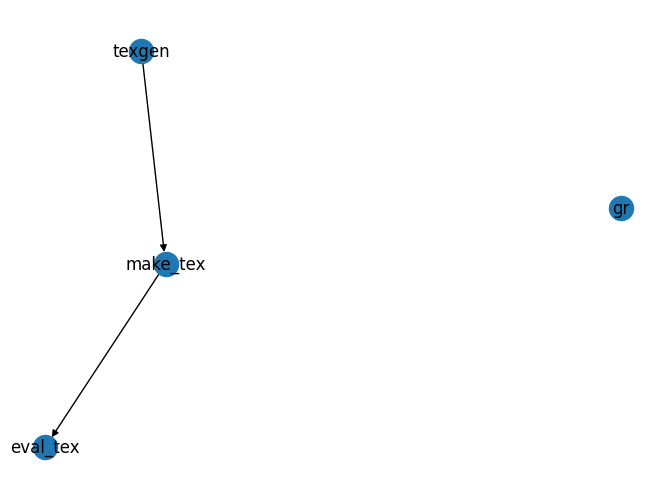

In [401]:
nx.draw(G, with_labels=True)

In [338]:
run_hashes = set(hash_run(run) for run in existing)

# find specs that are not in existing
to_run = set()
for s in G.nodes:
    spec_hash = hash_spec(s)
    if spec_hash not in run_hashes:
        to_run.add(s)

# recursively find specs that depend on the ones we found
to_run_descendants = set()
for node in to_run:
    descendants = nx.descendants(G, node)
    to_run_descendants |= descendants

to_run |= to_run_descendants
to_run

{eval_tex, make_tex, texgen}

In [339]:
to_run_hashes = set(hash_spec(s) for s in to_run)
spec_hashes = set(hash_spec(s) for s in specification)

# delete run if:
# - it is not in specification
# - it is in to_run
# - it is duplicate

observed_hashes = set()

to_del_rerun = set()
to_del_not_in_spec = set()
to_del_duplicate = set()

for e in existing:
    hash = hash_run(e)
    if hash in to_run_hashes:
        to_del_rerun.add(e)

    if hash not in spec_hashes:
        to_del_not_in_spec.add(e)

    if hash in observed_hashes:
        to_del_duplicate.add(e)
    
    observed_hashes.add(hash)

to_del = to_del_rerun | to_del_not_in_spec | to_del_duplicate
to_del

{3, 4, 9}